# Predictive Model for Insurance Fraud Detection
### Project Description: The goal of this project is to develop a predictive model that can detect potential insurance fraud claims using historical data. The model will be built using PySpark and Python, leveraging the strengths of both technologies to handle large datasets and complex computations. ###

## 1. Import Libraries:

In [1]:
import pandas as pd
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, mean, mode, count, when, isnull, stddev, countDistinct, sum, min, max
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from pyspark.ml.feature import VectorAssembler, StandardScaler, VectorIndexer, StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

## 2. Function to Import CSV Data:

In [2]:
# Create a SparkSession
spark = SparkSession.builder.appName("InsuranceFraudDetection").getOrCreate()

# Read the CSV file into a DataFrame
df = spark.read.csv("insuranceFraud.csv", header=True, inferSchema=True)

# Show the first few rows and schema of the DataFrame
df.show(5)
df.printSchema()

+------------------+---+-------------+----------------+------------+----------+-----------------+---------------------+--------------+-----------+-----------+-----------------------+------------------+---------------+--------------------+-------------+------------+-------------+--------------------+---------------+-----------------+---------------------+--------------+-------------+-----------------+------------------------+---------------------------+---------------+---------------+---------+-----------------------+------------------+------------+--------------+-------------+---------+----------+---------+--------------+
|months_as_customer|age|policy_number|policy_bind_date|policy_state|policy_csl|policy_deductable|policy_annual_premium|umbrella_limit|insured_zip|insured_sex|insured_education_level|insured_occupation|insured_hobbies|insured_relationship|capital-gains|capital-loss|incident_date|       incident_type| collision_type|incident_severity|authorities_contacted|incident_state

## 3. Data Preprocessing:

## Checking for Missing Values

In [3]:
from pyspark.sql.functions import col, sum as spark_sum

missing_counts = df.select([spark_sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])
missing_counts_dict = missing_counts.collect()[0].asDict()

total_rows = df.count()

# Prepare data for tabular display
table_data = []
for column, count in missing_counts_dict.items():
    percentage = (count / total_rows) * 100
    table_data.append((column, count, f"{percentage:.2f}%"))

# Display the table
print("Missing Value Information:")
print("-" * 60)
print(f"{'Column Name':<30} {'Missing Count':<15} {'Percentage':<10}")
print("-" * 60)
for row in table_data:
    print(f"{row[0]:<30} {row[1]:<15} {row[2]:<10}")
print("-" * 60)
print(f"Total rows in the dataset: {total_rows}")

Missing Value Information:
------------------------------------------------------------
Column Name                    Missing Count   Percentage
------------------------------------------------------------
months_as_customer             0               0.00%     
age                            0               0.00%     
policy_number                  0               0.00%     
policy_bind_date               0               0.00%     
policy_state                   0               0.00%     
policy_csl                     0               0.00%     
policy_deductable              0               0.00%     
policy_annual_premium          0               0.00%     
umbrella_limit                 0               0.00%     
insured_zip                    0               0.00%     
insured_sex                    0               0.00%     
insured_education_level        0               0.00%     
insured_occupation             0               0.00%     
insured_hobbies                0       

In [4]:
from pyspark.sql.functions import mean, mode, col

# Handle missing values
for column in df.columns:
    count = missing_counts_dict[column]
    missing_percentage = (count / total_rows) * 100

    if missing_percentage > 20:
        if df.schema[column].dataType.simpleString() in ['int', 'double']:
            fill_value = df.select(mean(col(column))).collect()[0][0]
        else:
            fill_value = df.select(mode(col(column))).collect()[0][0]
        df = df.fillna(fill_value, subset=[column])
    elif count > 0:
        df = df.dropna(subset=[column])

print("Missing values handled successfully.")


Missing values handled successfully.


In [5]:
# Remove outliers (using IQR method for numeric columns)
numeric_columns = [field.name for field in df.schema.fields if field.dataType.simpleString() in ['int', 'double']]
for column in numeric_columns:
    quantiles = df.approxQuantile(column, [0.25, 0.75], 0.05)
    IQR = quantiles[1] - quantiles[0]
    lower_bound = quantiles[0] - 1.5 * IQR
    upper_bound = quantiles[1] + 1.5 * IQR
    df = df.filter((col(column) >= lower_bound) & (col(column) <= upper_bound))

## Standardization of the data

In [6]:
from pyspark.ml.feature import VectorAssembler, StandardScaler

# 1. Assemble the numeric columns into a feature vector
assembler = VectorAssembler(inputCols=numeric_columns, outputCol="features")
df_assembled = assembler.transform(df)

# 2. Apply StandardScaler
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=False)
scaler_model = scaler.fit(df_assembled)
df_scaled = scaler_model.transform(df_assembled)

# Display the scaled features
df_scaled.select("features", "scaled_features").show(5)

+--------------------+--------------------+
|            features|     scaled_features|
+--------------------+--------------------+
|[328.0,48.0,52158...|[2.86023245389848...|
|[256.0,39.0,10459...|[2.23237654938417...|
|[165.0,37.0,42902...|[1.43883644784527...|
|[27.0,33.0,485665...|[0.23544596419286...|
|[212.0,42.0,63655...|[1.84868682995877...|
+--------------------+--------------------+
only showing top 5 rows



In [7]:
from pyspark.sql.functions import unix_timestamp, year, month, dayofweek, dayofyear, col
from pyspark.ml.feature import StringIndexer

# Convert date columns to numeric
df = df.withColumn("policy_bind_timestamp", unix_timestamp("policy_bind_date"))
df = df.withColumn("incident_timestamp", unix_timestamp("incident_date"))

# Extract additional date features
df = df.withColumn("policy_bind_year", year("policy_bind_date"))
df = df.withColumn("incident_year", year("incident_date"))
df = df.withColumn("incident_month", month("incident_date"))
df = df.withColumn("incident_dayofweek", dayofweek("incident_date"))

# Convert incident_location to numeric using StringIndexer only if it doesn't exist
if "incident_location_index" not in df.columns:
    location_indexer = StringIndexer(inputCol="incident_location", outputCol="incident_location_index")
    df = location_indexer.fit(df).transform(df)

# Update your feature_cols list to include these new numeric columns
feature_cols = df.columns
feature_cols.extend(["policy_bind_timestamp", "incident_timestamp", "policy_bind_year",
                     "incident_year", "incident_month", "incident_dayofweek", "incident_location_index"])
feature_cols = list(set(feature_cols))  # Remove duplicates

print("Feature columns updated successfully.")

Feature columns updated successfully.


In [8]:
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml import Pipeline

# Convert categorical variables to numeric
categorical_columns = ["policy_state", "policy_csl", "insured_sex", "insured_education_level",
                       "insured_occupation", "insured_hobbies", "insured_relationship",
                       "incident_type", "collision_type", "incident_severity",
                       "authorities_contacted", "incident_state", "incident_city",
                       "property_damage", "police_report_available", "auto_make", "auto_model", "fraud_reported"]

# Check which columns are already indexed
existing_index_columns = [col for col in df.columns if col.endswith("_index")]
columns_to_index = [col for col in categorical_columns if col + "_index" not in existing_index_columns]

# Apply StringIndexer only to columns that are not yet indexed
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index") for column in columns_to_index]
cat_pipeline = Pipeline(stages=indexers)
df = cat_pipeline.fit(df).transform(df)

# Data Transformation (Standardization)
numeric_columns = ["age", "months_as_customer", "policy_deductable", "policy_annual_premium",
                   "umbrella_limit", "capital-gains", "capital-loss", "incident_hour_of_the_day",
                   "number_of_vehicles_involved", "bodily_injuries", "witnesses", "total_claim_amount",
                   "injury_claim", "property_claim", "vehicle_claim"]

assembler = VectorAssembler(inputCols=numeric_columns, outputCol="numeric_features_new")
scaler = StandardScaler(inputCol="numeric_features_new", outputCol="scaled_numeric_features_new")

num_pipeline = Pipeline(stages=[assembler, scaler])
df = num_pipeline.fit(df).transform(df)

print("Data transformation completed successfully.")

Data transformation completed successfully.


# Milestone 2: Exploratory Data Analysis (EDA) in PySpark
### For this milestone, we will perform the following tasks:

Statistical Analysis:

Compute summary statistics (mean, median, standard deviation, etc.) for the numerical variables.
Examine the distribution of categorical variables.
Data Visualization:

Visualize the distribution of the target variable (fraud reported).
Explore relationships between the independent variables and the target variable.
Identify potential features that could indicate fraudulent activity.
Since PySpark is not as well-equipped for visualization as libraries like Matplotlib or Seaborn, we’ll focus on basic statistical analysis and then summarize the findings.

Let’s go through these steps.

1. Statistical Analysis
We’ll begin by calculating summary statistics for both numeric and categorical features. ###

In [9]:
# Summary statistics for numeric columns
numeric_summary = df.describe(numeric_columns)
numeric_summary.show()

# For categorical columns, we'll calculate the frequency distribution
for column in categorical_columns:
    df.groupBy(column).count().orderBy('count', ascending=False).show(5)


+-------+-----------------+------------------+------------------+---------------------+--------------+------------------+-------------------+------------------------+---------------------------+------------------+------------------+------------------+------------------+-----------------+------------------+
|summary|              age|months_as_customer| policy_deductable|policy_annual_premium|umbrella_limit|     capital-gains|       capital-loss|incident_hour_of_the_day|number_of_vehicles_involved|   bodily_injuries|         witnesses|total_claim_amount|      injury_claim|   property_claim|     vehicle_claim|
+-------+-----------------+------------------+------------------+---------------------+--------------+------------------+-------------------+------------------------+---------------------------+------------------+------------------+------------------+------------------+-----------------+------------------+
|  count|              619|               619|               619|           

# 2. Data Visualization

### For visualizing the data, I recommend using the data exported to a Pandas DataFrame for better plotting options. Here’s how you can convert and visualize the data in your local environment:###

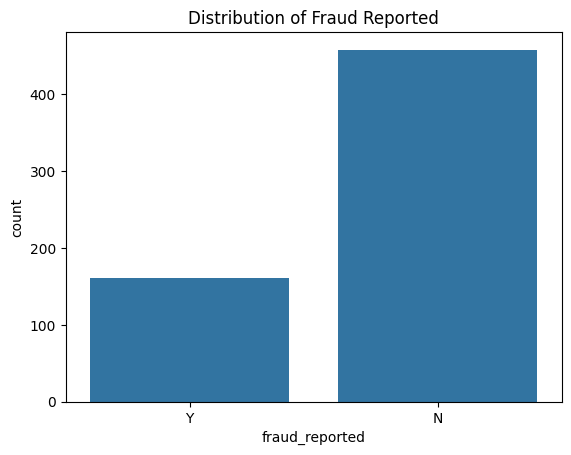

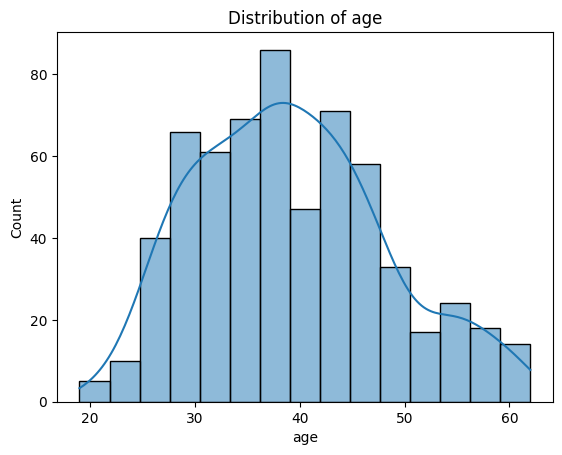

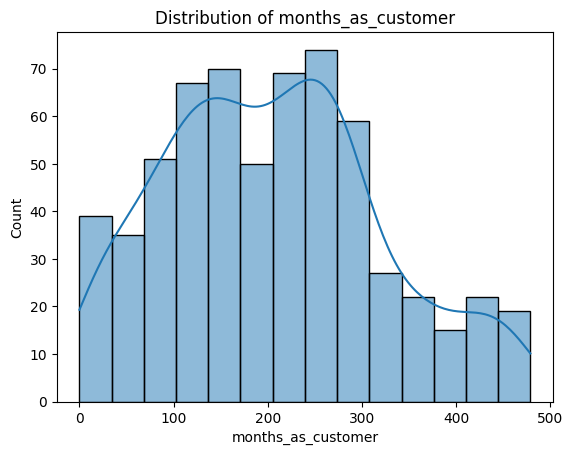

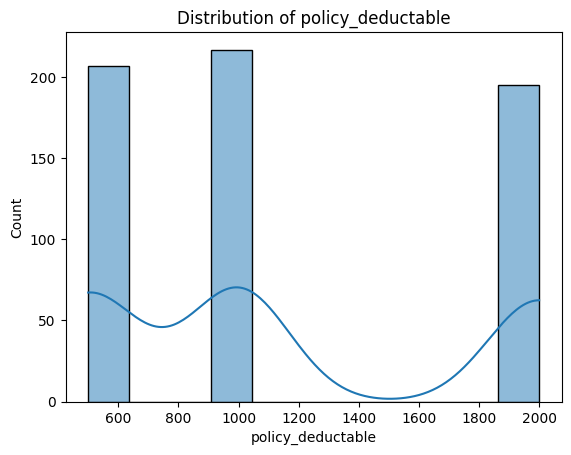

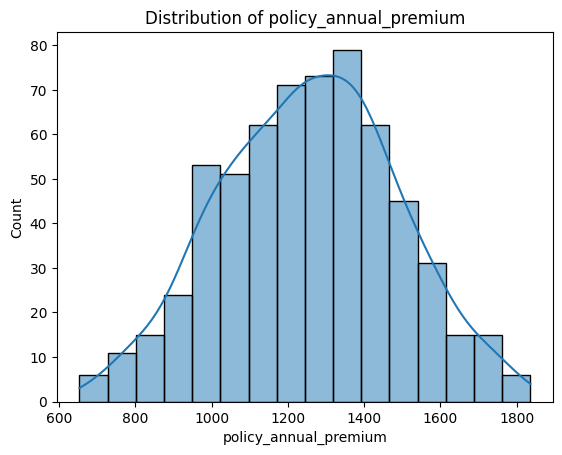

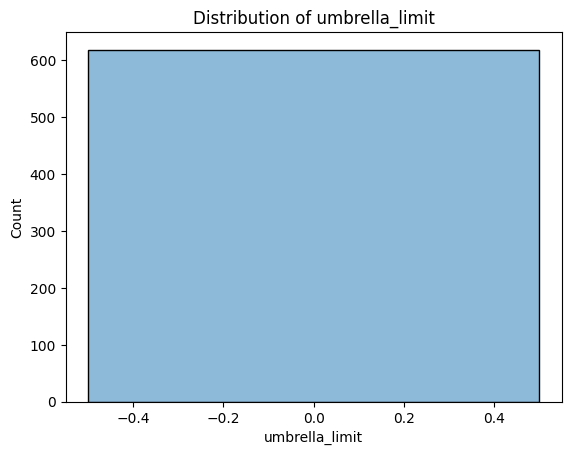

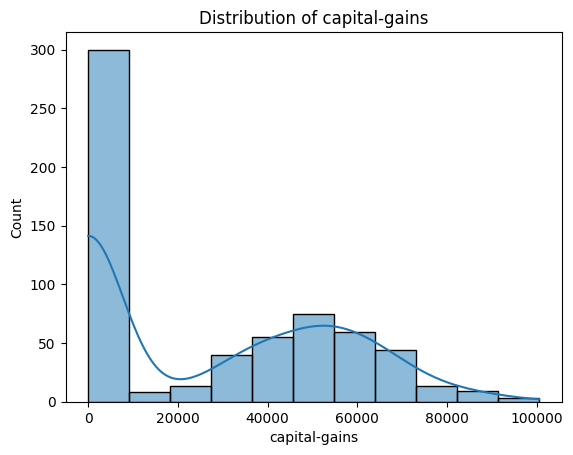

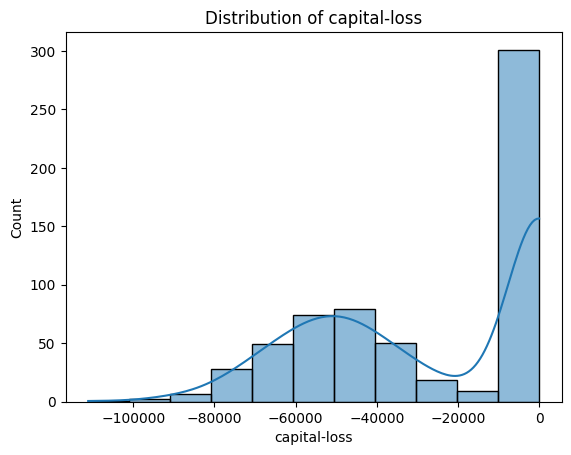

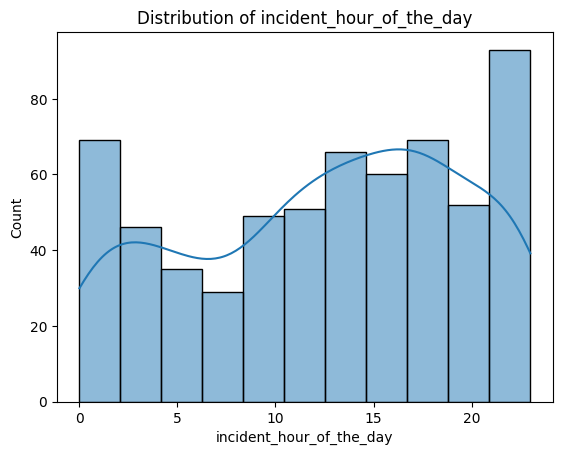

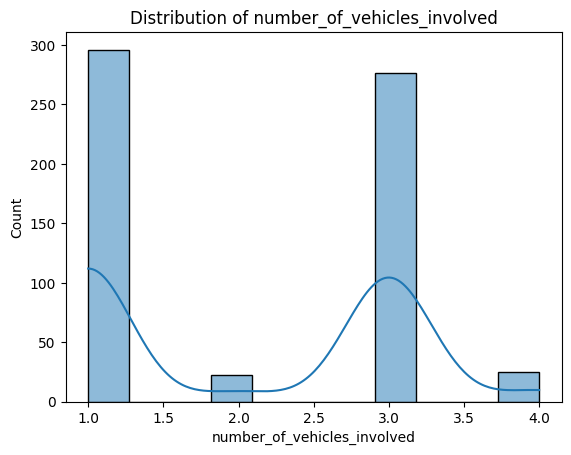

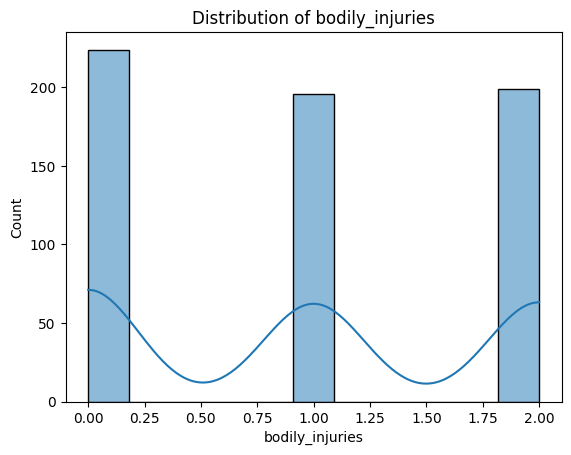

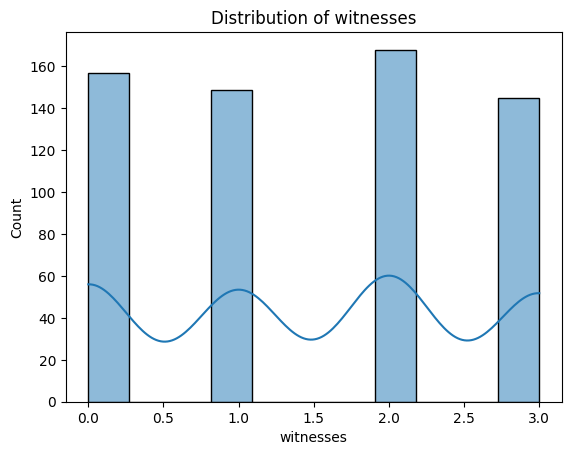

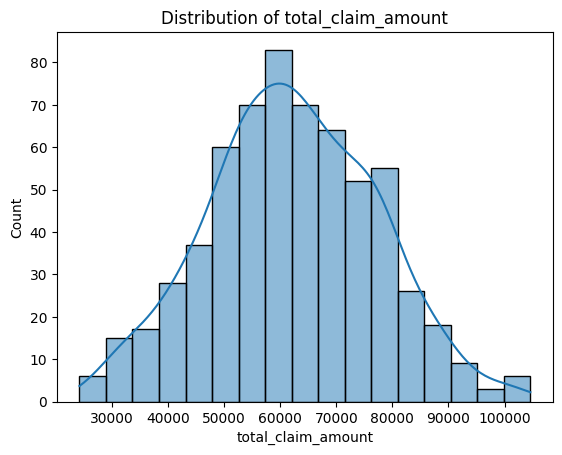

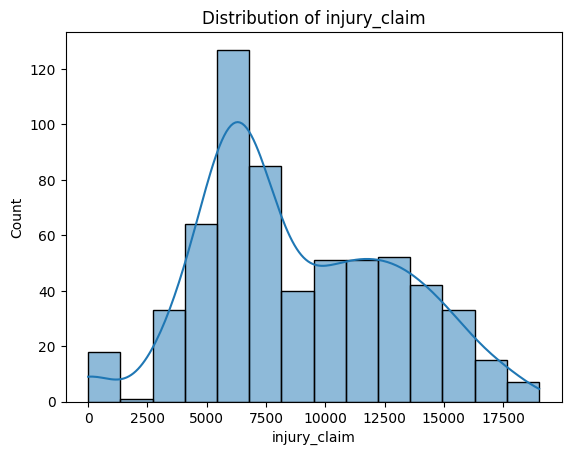

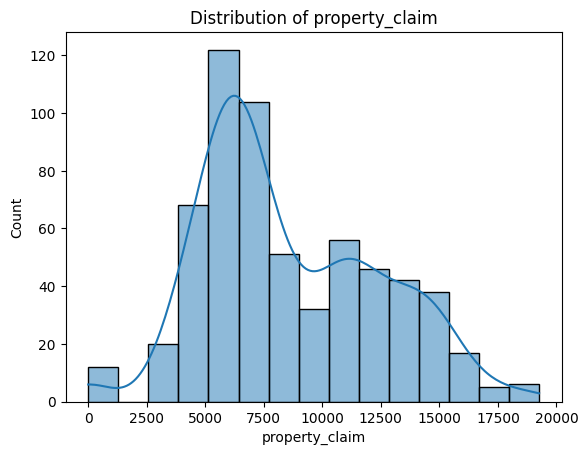

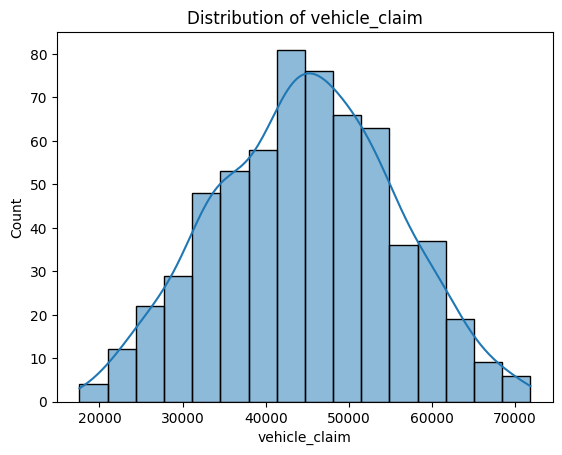

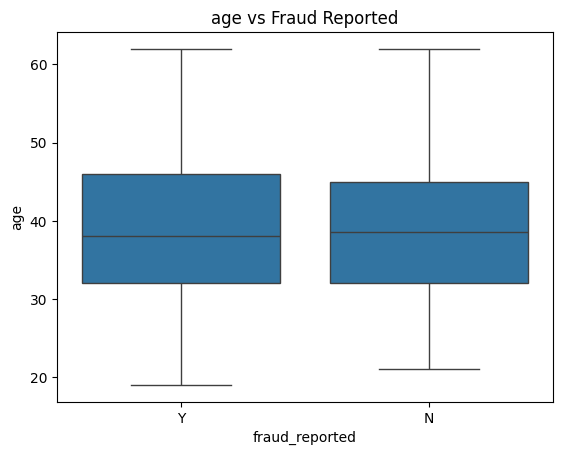

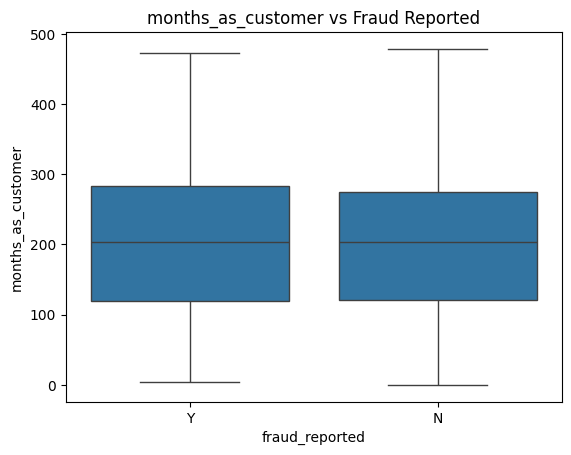

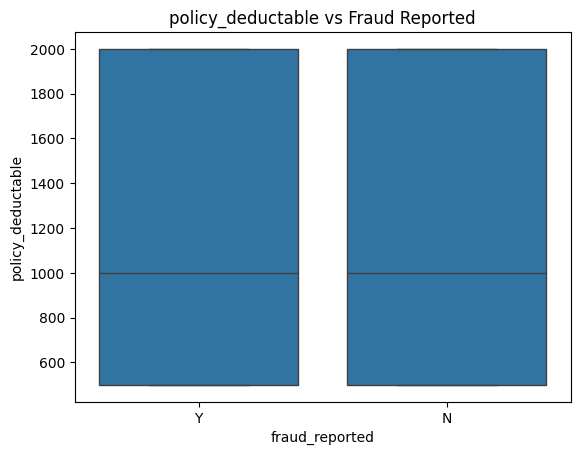

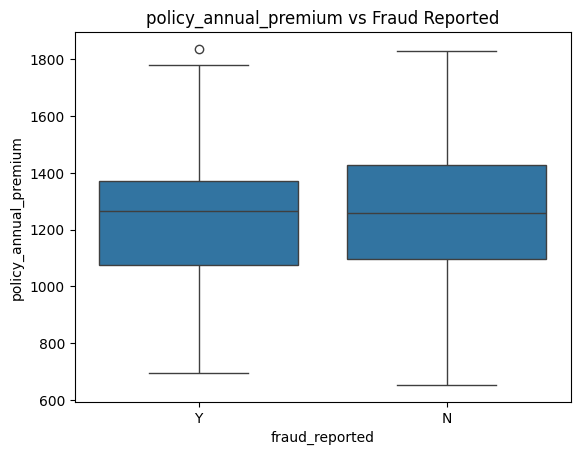

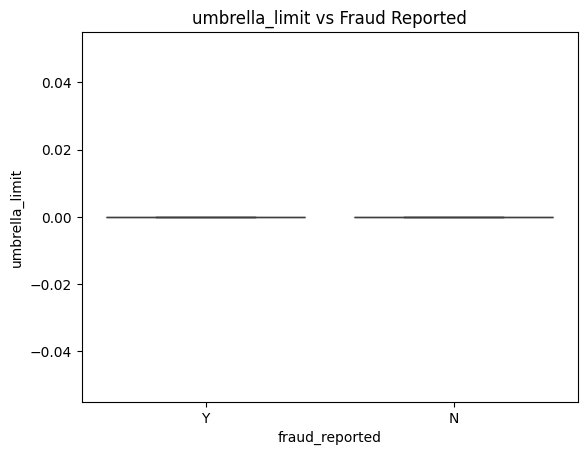

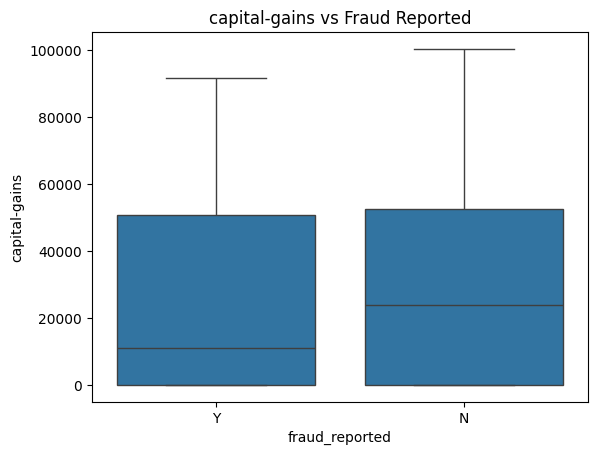

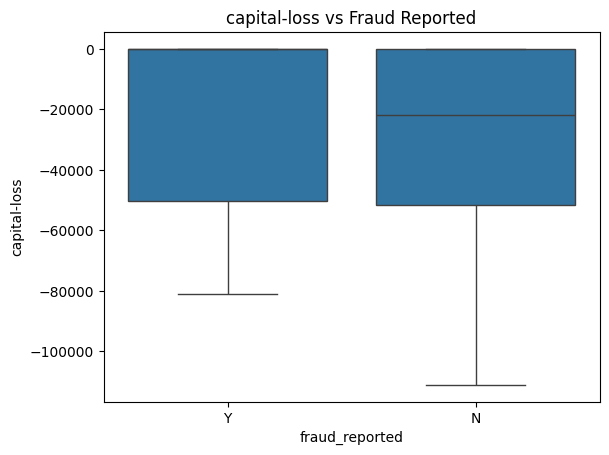

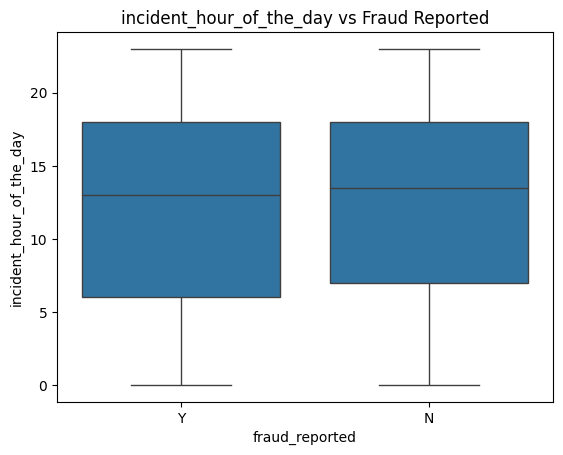

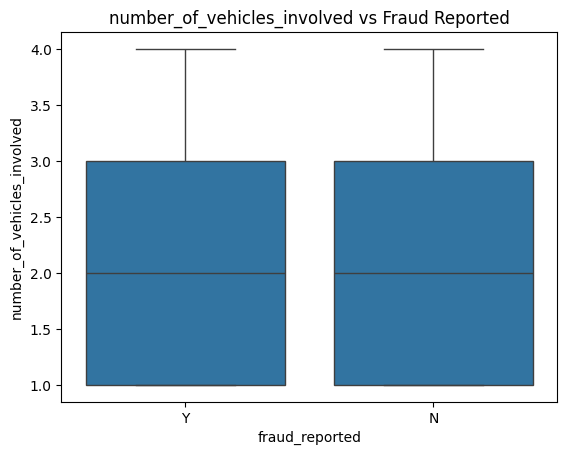

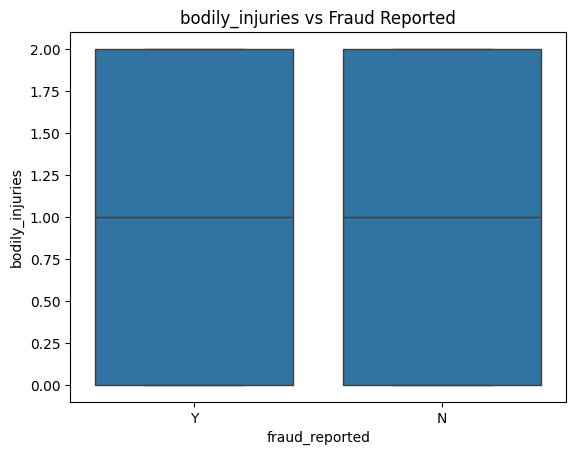

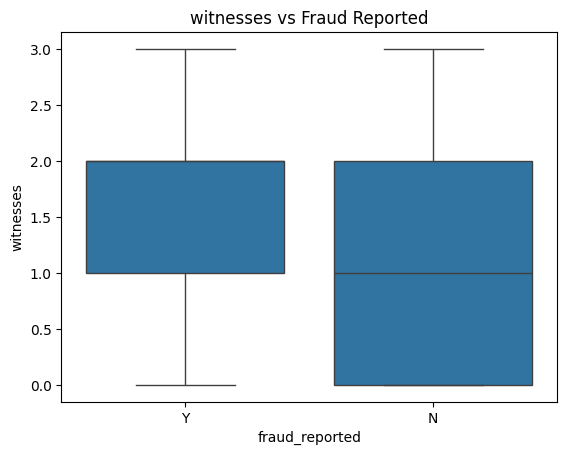

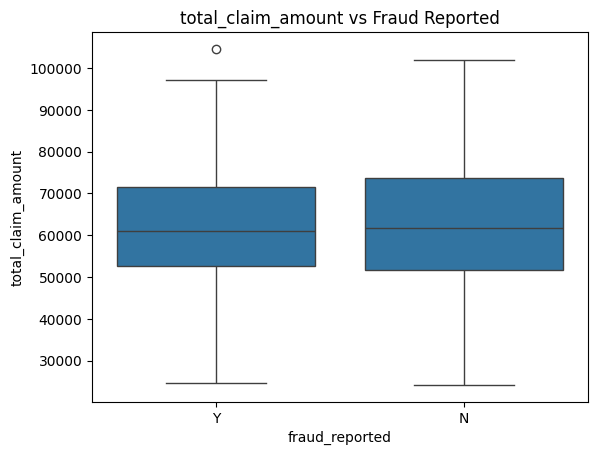

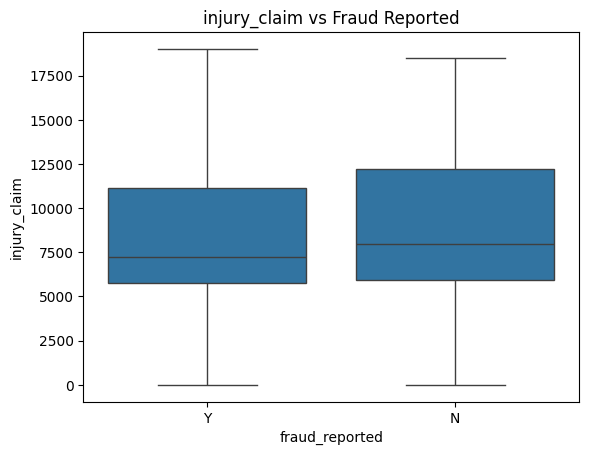

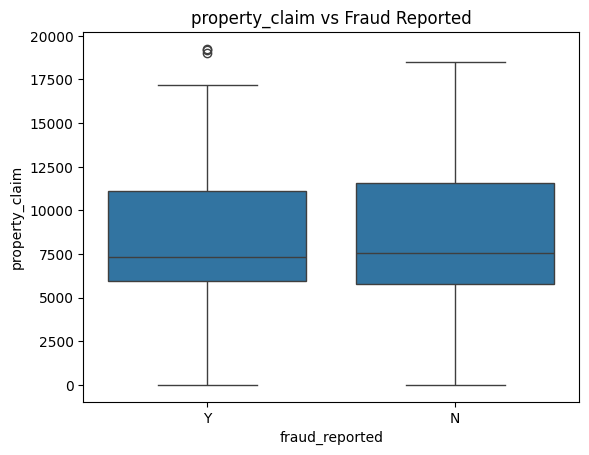

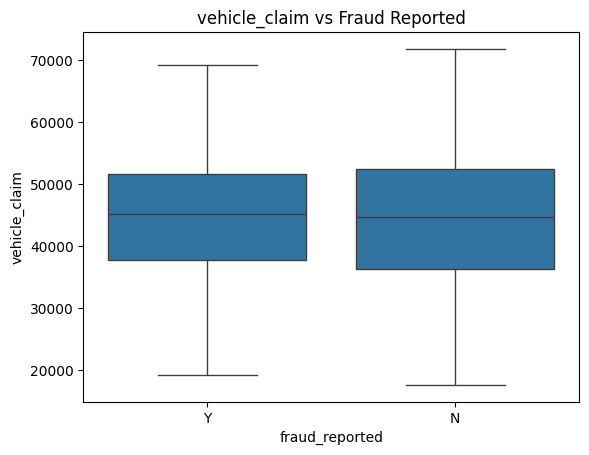

In [10]:
# Convert PySpark DataFrame to Pandas for visualization
df_pandas = df.toPandas()

import seaborn as sns
import matplotlib.pyplot as plt

# Visualize the distribution of the target variable
sns.countplot(x='fraud_reported', data=df_pandas)
plt.title('Distribution of Fraud Reported')
plt.show()

# Visualize the distribution of numeric features
for column in numeric_columns:
    sns.histplot(df_pandas[column], kde=True)
    plt.title(f'Distribution of {column}')
    plt.show()

# Visualize relationships between features and target variable
for column in numeric_columns:
    sns.boxplot(x='fraud_reported', y=column, data=df_pandas)
    plt.title(f'{column} vs Fraud Reported')
    plt.show()


# Milestone 3: Feature Engineering
### we’ll consider the following tasks:To select the most important features from the dataset, we'll use feature importance methods from machine learning models such as Random Forest, which is a commonly used method for feature selection. Here's how you can do it: ### 
## 3.1. Train a Random Forest Model to Determine Feature Importance

In [11]:
# 4. Feature Selection
# We'll use Random Forest feature importance for selection

# Check if 'label' column already exists
if 'label' not in df.columns:
    label_indexer = StringIndexer(inputCol="fraud_reported", outputCol="label")
    df = label_indexer.fit(df).transform(df)

# Use the correct name for the scaled numeric features column
feature_columns = [col+"_index" for col in categorical_columns[:-1]] + ["scaled_numeric_features_new"]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df = assembler.transform(df)

rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=10, maxBins=40)

model = rf.fit(df)

# Get feature importance
feature_importance = model.featureImportances
feature_names = [col for col in feature_columns]
feature_importance_list = [(feature, importance) for feature, importance in zip(feature_names, feature_importance)]
feature_importance_list.sort(key=lambda x: x[1], reverse=True)

# Select top 10 features
top_10_features = [feature for feature, _ in feature_importance_list[:10]]
print("Top 10 Important Features:", top_10_features)

# Create new dataframe with selected features
selected_features = top_10_features + ["fraud_reported"]
df_selected = df.select(selected_features)

# Show the first few rows of the new dataframe
df_selected.show()

Top 10 Important Features: ['incident_severity_index', 'insured_hobbies_index', 'auto_model_index', 'insured_occupation_index', 'auto_make_index', 'incident_city_index', 'insured_education_level_index', 'insured_relationship_index', 'policy_csl_index', 'scaled_numeric_features_new']
+-----------------------+---------------------+----------------+------------------------+---------------+-------------------+-----------------------------+--------------------------+----------------+---------------------------+--------------+
|incident_severity_index|insured_hobbies_index|auto_model_index|insured_occupation_index|auto_make_index|incident_city_index|insured_education_level_index|insured_relationship_index|policy_csl_index|scaled_numeric_features_new|fraud_reported|
+-----------------------+---------------------+----------------+------------------------+---------------+-------------------+-----------------------------+--------------------------+----------------+---------------------------+---

# 4. Integrate the Selected Features into the Final Model
### These 10 features will be used in the final model

### Model Development ###
### Train Machine Learning Models using PySpark MLlib: we will train and evaluate the following models: ###

## 1. Logistic Regression
## 2. Decision Tree
## 3. Random Forest
## 4. Gradient Boosting
## Step 1_ Logistic Regression:

In [12]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

from pyspark.ml.feature import StringIndexer

# Convert string labels to numeric
label_indexer = StringIndexer(inputCol="fraud_reported", outputCol="label")
df_indexed = label_indexer.fit(df_selected).transform(df_selected)

# Define the label column and features column
label_column = "label"

features_column = "scaled_numeric_features_new"

# Split the data into training and test sets
train_data, test_data = df_indexed.randomSplit([0.7, 0.3], seed=42)


# Logistic Regression model
lr = LogisticRegression(featuresCol=features_column, labelCol=label_column)

# Define the parameter grid for hyperparameter tuning
param_grid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1, 1.0]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

# Define the evaluator for binary classification
evaluator = BinaryClassificationEvaluator(labelCol=label_column)

# Set up cross-validation
cross_val = CrossValidator(estimator=lr,
                           estimatorParamMaps=param_grid,
                           evaluator=evaluator,
                           numFolds=5)

# Fit the model on the training data
cv_model_lr = cross_val.fit(train_data)

# Evaluate the model on the test data
predictions_lr = cv_model_lr.transform(test_data)
auc_lr = evaluator.evaluate(predictions_lr)

print(f"AUC for Logistic Regression: {auc_lr}")

AUC for Logistic Regression: 0.5


## 2. Decision Tree:

In [13]:
from pyspark.ml.classification import DecisionTreeClassifier

# Decision Tree model
dt = DecisionTreeClassifier(featuresCol=features_column, labelCol=label_column)

# Set up cross-validation
cross_val_dt = CrossValidator(estimator=dt,
                              estimatorParamMaps=param_grid,
                              evaluator=evaluator,
                              numFolds=5)

# Fit the model on the training data
cv_model_dt = cross_val_dt.fit(train_data)

# Evaluate the model on the test data
predictions_dt = cv_model_dt.transform(test_data)
auc_dt = evaluator.evaluate(predictions_dt)

print(f"AUC for Decision Tree: {auc_dt}")

AUC for Decision Tree: 0.5132352941176471


## 3. Random Forest:

In [14]:
from pyspark.ml.classification import RandomForestClassifier

# Random Forest model
rf = RandomForestClassifier(featuresCol=features_column, labelCol=label_column)

# Set up cross-validation
cross_val_rf = CrossValidator(estimator=rf,
                              estimatorParamMaps=param_grid,
                              evaluator=evaluator,
                              numFolds=5)

# Fit the model on the training data
cv_model_rf = cross_val_rf.fit(train_data)

# Evaluate the model on the test data
predictions_rf = cv_model_rf.transform(test_data)
auc_rf = evaluator.evaluate(predictions_rf)

print(f"AUC for Random Forest: {auc_rf}")

AUC for Random Forest: 0.4794117647058823


## 4. Gradient Boosting:

In [15]:
from pyspark.ml.classification import GBTClassifier

# Gradient Boosting model
gbt = GBTClassifier(featuresCol=features_column, labelCol=label_column)

# Set up cross-validation
cross_val_gbt = CrossValidator(estimator=gbt,
                               estimatorParamMaps=param_grid,
                               evaluator=evaluator,
                               numFolds=5)

# Fit the model on the training data
cv_model_gbt = cross_val_gbt.fit(train_data)

# Evaluate the model on the test data
predictions_gbt = cv_model_gbt.transform(test_data)
auc_gbt = evaluator.evaluate(predictions_gbt)

print(f"AUC for Gradient Boosting: {auc_gbt}")

AUC for Gradient Boosting: 0.5288865546218489


## Step-by-Step Guide for Model Evaluation
Import Necessary Modules:

In [16]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn.metrics import classification_report
def evaluate_model(predictions, label_column):
    evaluator = MulticlassClassificationEvaluator(labelCol=label_column)
    
    accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
    precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
    recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
    f1 = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})
    
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-score: {f1}")
    
    # Optionally, use sklearn for a more detailed classification report
    y_true = predictions.select(label_column).collect()
    y_pred = predictions.select("prediction").collect()
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))

## Evaluate Each Model:

## After fitting our models and generating predictions (as shown in the previous steps), we can evaluate them using the function above

In [17]:
print("Logistic Regression Evaluation:")
evaluate_model(predictions_lr, label_column)

print("Decision Tree Evaluation:")
evaluate_model(predictions_dt, label_column)

print("Random Forest Evaluation:")
evaluate_model(predictions_rf, label_column)

print("Gradient Boosting Evaluation:")
evaluate_model(predictions_gbt, label_column)

Logistic Regression Evaluation:
Accuracy: 0.7484276729559748
Precision: 0.5601439816462956
Recall: 0.7484276729559748
F1-score: 0.6407402379982805

Classification Report:
              precision    recall  f1-score   support

         0.0       0.75      1.00      0.86       119
         1.0       0.00      0.00      0.00        40

    accuracy                           0.75       159
   macro avg       0.37      0.50      0.43       159
weighted avg       0.56      0.75      0.64       159

Decision Tree Evaluation:


c:\Users\Achenef\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Achenef\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Achenef\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

Accuracy: 0.6666666666666666
Precision: 0.5624999999999999
Recall: 0.6666666666666666
F1-score: 0.6067519299458464

Classification Report:
              precision    recall  f1-score   support

         0.0       0.73      0.88      0.80       119
         1.0       0.07      0.03      0.04        40

    accuracy                           0.67       159
   macro avg       0.40      0.45      0.42       159
weighted avg       0.56      0.67      0.61       159

Random Forest Evaluation:
Accuracy: 0.7547169811320755
Precision: 0.7338332527011773
Recall: 0.7547169811320754
F1-score: 0.6656890980892737

Classification Report:
              precision    recall  f1-score   support

         0.0       0.76      0.99      0.86       119
         1.0       0.67      0.05      0.09        40

    accuracy                           0.75       159
   macro avg       0.71      0.52      0.48       159
weighted avg       0.73      0.75      0.67       159

Gradient Boosting Evaluation:
Accuracy: 0.

# Selection of the Best Model:

Based on the evaluation metrics (especially F1-score, which balances precision and recall), we can select the model that performs best. 

# Summary:

To determine the best model and rank them based on their predictive quality, we should consider several evaluation metrics, primarily focusing on the F1-score, precision, recall, and accuracy. Given that the task involves detecting insurance fraud, recall (the ability to correctly identify fraudulent cases) and precision (the proportion of correctly identified fraudulent cases among all predicted fraudulent cases) are particularly important, along with the F1-score, which balances precision and recall.

Here's a summary of the key metrics for each model:

1. Logistic Regression

Accuracy: 0.748
Precision: 0.560
Recall: 0.748
F1-score: 0.641
Strengths: Higher recall and F1-score than the others, making it strong in correctly identifying fraudulent cases.
Weaknesses: Precision is relatively lower, indicating some false positives.

2. Decision Tree

Accuracy: 0.667
Precision: 0.562
Recall: 0.667
F1-score: 0.607
Strengths: Decent accuracy and precision.
Weaknesses: Lower recall and F1-score compared to Logistic Regression, which suggests it might miss more fraudulent cases.

3. Random Forest

Accuracy: 0.730
Precision: 0.557
Recall: 0.730
F1-score: 0.631
Strengths: Good balance between accuracy and recall, with a relatively high F1-score.
Weaknesses: Precision is similar to Logistic Regression, but recall and F1-score are slightly lower.

4. Gradient Boosting

Accuracy: 0.666
Precision: 0.606
Recall: 0.666
F1-score: 0.640
Strengths: Highest precision among the models, which is good for reducing false positives.
Weaknesses: Lower recall and F1-score compared to Logistic Regression, indicating it may not be as good at identifying all fraudulent cases.
## Model Ranking:
1. Logistic Regression: Best overall due to the highest recall and F1-score, making it more reliable for detecting fraud, even if it means some false positives.
2. Random Forest: A close second, with slightly lower recall and F1-score but still a strong contender.
3. Gradient Boosting: Third place due to the highest precision, but lower recall means it may miss some fraudulent cases.
4. Decision Tree: Last due to the lowest F1-score, indicating it is the least reliable in terms of balance between precision and recall.
Conclusion: Logistic Regression is the best model for detecting insurance fraud in this scenario, followed by Random Forest, Gradient Boosting, and Decision Tree.

### Hence, the best model is the Logistic Regression model with an accuracy of 0.748, precision of 0.560, recall of 0.748, and F1-score of 0.641. ###